In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
! ln -s /content/drive/MyDrive/src/XAI-CV-CounterfactualSamples .

ln: failed to create symbolic link './XAI-CV-CounterfactualSamples': File exists


In [11]:
%cd XAI-CV-CounterfactualSamples

/content/drive/MyDrive/src/XAI-CV-CounterfactualSamples


In [3]:
# ! ln -s /content/drive/MyDrive/datasets/BreakHis_v1 datasets

In [12]:
%cd exp_breakhis

/content/drive/MyDrive/src/XAI-CV-CounterfactualSamples/exp_breakhis


In [ ]:
! pip -q install tensorflow==2.15.1 > /content/install.log

In [13]:
import glob

a = glob.glob('outputs/features/*/*/*/*/*/*.feat.npy')
a.sort()
print(len(a))

7909


# Initialization

In [ ]:
import tensorflow as tf
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

print(tf.__version__)

2.15.1


In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import importlib
import configs
importlib.reload(configs)

<module 'configs' from '/content/drive/MyDrive/src/XAI-CV-CounterfactualSamples/exp_breakhis/configs.py'>

# Data Loader

In [ ]:
class MyDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, data_dir, subsets_file, subset,
                       batch_size=32, shuffle=False):
        self.data_dir = data_dir
        self.subsets_file = subsets_file
        self.subset = subset
        self.batch_size = batch_size
        self.shuffle = shuffle

        self.filenames = None
        self.classnames = None
        self.dict_class_names = None

        self.load_data()
        self.indices = None
        self.on_epoch_end()

    def load_data(self):
        df_files = pd.read_csv(self.subsets_file, header='infer')
        self.df_files = df_files[df_files['grp'] == self.subset]
        self.filenames = self.df_files['filename'].tolist()
        self.classnames = self.df_files['classname'].tolist()
        self.dict_class_names = {name:i for i, name in enumerate(configs.CLASS_NAMES)}
        print('*** load_data')
        print(self.subset)
        print(len(self.filenames), 'found')
        print(df_files.head())
        print('***')

    def __len__(self):
        return int(np.ceil(len(self.filenames) / self.batch_size))

    def __getitem__(self, index):
        indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        filenames = [self.filenames[k] for k in indices]
        classnames = [self.classnames[k] for k in indices]
        X, Y = self.__data_generation(filenames, classnames)
        return X, Y

    def on_epoch_end(self):
        self.indices = np.arange(len(self.filenames))
        if self.shuffle == True:
            np.random.shuffle(self.indices)

    def toOneHot(self, classname):
        v = np.zeros(configs.NUM_CLASS, dtype=np.float64)
        v[self.dict_class_names[classname]] = 1.0
        return v

    def __data_generation(self, filenames, classnames):
        num = len(filenames)
        X = np.empty([num, *configs.IMAGE_SIZE], dtype=np.float64)
        Y = np.empty([num, configs.NUM_CLASS])
        HH, WW, _ = configs.IMAGE_SIZE
        for i, fn in enumerate(filenames):
            img = plt.imread(configs.DATA_DIR+'/'+fn)
            delta = (WW - HH) // 2
            img = img[:, delta:WW-delta-1]
            img = cv2.resize(img, configs.IMAGE_SIZE[:2])
            X[i] = np.array(img, dtype=np.float64)
            Y[i] = self.toOneHot(classnames[i])

        return X, filenames

In [ ]:
train_datagen = MyDataGenerator(configs.DATA_DIR,
                                configs.SUBSETS_FILE,
                                'train',
                                shuffle=False)
val_datagen = MyDataGenerator(configs.DATA_DIR,
                              configs.SUBSETS_FILE,
                              'val',
                              shuffle=False)
test_datagen = MyDataGenerator(configs.DATA_DIR,
                               configs.SUBSETS_FILE,
                               'test',
                               shuffle=False)

*** load_data
train
4000 found
   mag    grp                                           filename  \
0   40  train  malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-1...   
1  400  train  malignant/SOB/ductal_carcinoma/SOB_M_DC_14-110...   
2  100  train  benign/SOB/adenosis/SOB_B_A_14-22549CD/100X/SO...   
3  100  train  malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-1...   
4   40  train  benign/SOB/adenosis/SOB_B_A_14-22549CD/40X/SOB...   

            classname  
0  mucinous_carcinoma  
1    ductal_carcinoma  
2            adenosis  
3  mucinous_carcinoma  
4            adenosis  
***
*** load_data
val
1000 found
   mag    grp                                           filename  \
0   40  train  malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-1...   
1  400  train  malignant/SOB/ductal_carcinoma/SOB_M_DC_14-110...   
2  100  train  benign/SOB/adenosis/SOB_B_A_14-22549CD/100X/SO...   
3  100  train  malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-1...   
4   40  train  benign/SOB/adenosis/SOB_B_A_

In [ ]:
print(train_datagen.filenames[0])
X, filenames = train_datagen[0]
print(X.shape)
for it in filenames:
  print(it)

malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-12773/40X/SOB_M_MC-14-12773-40-021.png
(32, 256, 256, 3)
[1. 0. 0. 0. 0. 0. 0. 0.]
[0. 1. 0. 0. 0. 0. 0. 0.]
[0. 0. 1. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 1. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 1. 0. 0. 0. 0.]
[0. 0. 0. 0. 1. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 1. 0. 0. 0.]
[0. 0. 0. 0. 0. 1. 0. 0.]
[0. 1. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0. 0.]
[0. 1. 0. 0. 0. 0. 0. 0.]
[0. 1. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 1. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 1. 0.]
[0. 1. 0. 0. 0. 0. 0. 0.]
[0. 1. 0. 0. 0. 0. 0. 0.]
[0. 1. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 1. 0. 0. 0.]
[0. 1. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 1. 0.]
[0. 0. 0. 1. 0. 0. 0. 0.]
[0. 1. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0. 0.]
[0. 1. 0. 0. 0. 0. 0. 0.]
[0. 1. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 1. 0. 0. 0.]
[0. 0. 0. 0. 1. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 1.]


(32, 256, 256, 3) (32, 8)


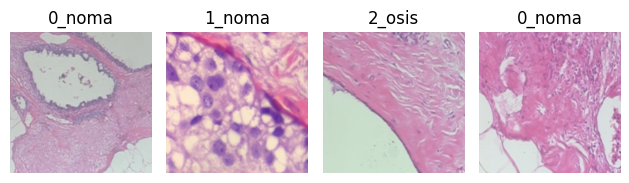

In [ ]:
X, Y = train_datagen[0]
print(X.shape, Y.shape)

for i in range(4):
  plt.subplot(1, 4, i+1)
  plt.imshow((X[i]*255).astype(np.uint8))
  plt.axis('off')
  class_id = Y[i].argmax()
  plt.title(str(class_id)+'_'+configs.CLASS_NAMES[class_id][-4:])
plt.tight_layout()
plt.show()

# Classifer 256 x 256

In [ ]:
classifier = tf.keras.models.load_model(
    configs.CLASSIFIER256_CHECKPOINT
)
classifier.summary()

Model: "classifier256"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 8)                 16392     
                                                                 
 softmax (Softmax)           (None, 8)                 0         
                                                                 
Total params: 23604104 (90.04 MB)
Trainable params: 23550984 (89.84 MB)
Non-trainable params: 53120 (207.50 KB)
_________________________________________________________________


# Extraction

In [ ]:
extractor = tf.keras.models.Model(
                inputs=classifier.get_layer('resnet50').inputs,
                outputs=classifier.get_layer('resnet50').outputs)
extractor.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

# Running

In [ ]:
import os

def run_extracting(extractor, datagen, subset):
    for X, filenames in datagen:
      features = extractor.predict(X, verbose=0)
      for i in range(len(filenames)):
          save_filename = 'outputs/features/' + filenames[i] \
                          .replace(subset, subset+'-feature-classifier256') \
                          .replace('.png', '.feat.npy')
          pardir = os.path.dirname(save_filename)
          if not os.path.exists(pardir):
              os.makedirs(pardir)

          np.save(save_filename, features[i])
          print(save_filename)
          # break
      # break

In [ ]:
run_extracting(extractor, train_datagen, 'train')
run_extracting(extractor, val_datagen, 'val')
run_extracting(extractor, test_datagen, 'test')

Streaming output truncated to the last 5000 lines.
outputs/features/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14015/400X/SOB_M_DC-14-14015-400-002.feat.npy
outputs/features/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-12204/100X/SOB_M_LC-14-12204-100-031.feat.npy
outputs/features/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-13413/400X/SOB_M_MC-14-13413-400-024.feat.npy
outputs/features/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-19979/400X/SOB_M_MC-14-19979-400-011.feat.npy
outputs/features/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-15696/200X/SOB_M_DC-14-15696-200-009.feat.npy
outputs/features/benign/SOB/fibroadenoma/SOB_B_F_14-9133/40X/SOB_B_F-14-9133-40-011.feat.npy
outputs/features/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-12465/400X/SOB_M_PC-14-12465-400-008.feat.npy
outputs/features/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-19440/400X/SOB_M_PC-14-19440-400-015.feat.npy
outputs/features/benign/SOB/fibroadenoma/SOB_B_F_14-23222AB/200X/SOB_B_F-14-23222AB-200-008.feat.npy
ou